<a href="https://colab.research.google.com/github/Ved2000/NLI-datasets-evaluation/blob/master/InferSent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/facebookresearch/InferSent.git

In [ ]:
cd /content/InferSent/

In [ ]:

!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

In [ ]:
!mkdir encoder
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
import torch
from models import InferSent
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [ ]:
infersent.build_vocab_k_words(100000)


Vocab size : 100000


2020-06-24 15:14:29,948 : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2020-06-24 15:14:29,949 : findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2020-06-24 15:14:29,950 : findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
2020-06-24 15:14:29,950 : findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2020-06-24 15:14:29,951 : findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2020-06-24 15:14:29,952 : findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2020-06-24 15:14:29,952 : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2020-06-24 15:14:29,953 : findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2020-06-24 15:14:29,954 

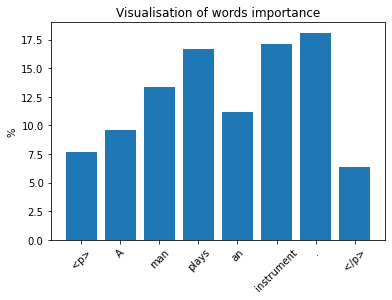

(tensor([[ 0.0075,  0.1772,  0.1542,  ..., -0.0334, -0.0174,  0.0108]],
        grad_fn=<MaxBackward0>), array([[0, 2, 5, ..., 2, 4, 5]]))

In [ ]:
infersent.visualize('A man plays an instrument.', tokenize=True)

In [ ]:
cd /content

/content


In [ ]:
!git clone https://github.com/facebookresearch/SentEval.git

In [ ]:
cd /content/SentEval/data/downstream/

/content/SentEval/data/downstream


In [ ]:
!./get_transfer_data.bash

In [ ]:
cd /content/SentEval/data/downstream/SICK

/content/SentEval/data/downstream/SICK


In [ ]:
cd /content/InferSent

/content/InferSent


In [ ]:
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

"""
InferSent models. See https://github.com/facebookresearch/InferSent.
"""

from __future__ import absolute_import, division, unicode_literals

import sys
import os
import torch
import logging

# get models.py from InferSent repo

from models import InferSent

# Set PATHs
PATH_SENTEVAL = '/content/SentEval'
PATH_TO_DATA = '/content/SentEval/data'
PATH_TO_W2V = '/content/InferSent/fastText/crawl-300d-2M.vec'  # or crawl-300d-2M.vec for V2
MODEL_PATH = '/content/InferSent/encoder/infersent2.pkl'
V = 2 # version of InferSent

assert os.path.isfile(MODEL_PATH) and os.path.isfile(PATH_TO_W2V), \
    'Set MODEL and GloVe PATHs'

# import senteval
sys.path.insert(0, PATH_SENTEVAL)
import senteval


def prepare(params, samples):
    params.infersent.build_vocab([' '.join(s) for s in samples], tokenize=False)


def batcher(params, batch):
    sentences = [' '.join(s) for s in batch]
    embeddings = params.infersent.encode(sentences, bsize=params.batch_size, tokenize=False)
    return embeddings


"""
Evaluation of trained model on Transfer Tasks (SentEval)
"""

# define senteval params
params_senteval = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 5}
params_senteval['classifier'] = {'nhid': 0, 'optim': 'rmsprop', 'batch_size': 8,
                                 'tenacity': 3, 'epoch_size': 2}
# Set up logger
logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.DEBUG)

if __name__ == "__main__":
    # Load InferSent model
    params_model = {'bsize': 8, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
    model = InferSent(params_model)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.set_w2v_path(PATH_TO_W2V)

    params_senteval['infersent'] = model.cuda()

    se = senteval.engine.SE(params_senteval, batcher, prepare)
    transfer_tasks = ['SICKEntailment']
    results = se.eval(transfer_tasks)
    print(results)

In [ ]:
cd /content/

/content


In [ ]:
sentences1 = []
with open('s1.train') as f:
    for line in f:
        sentences1.append(line.strip())
print(len(sentences1))

559191


In [ ]:
sent=[]
for i in range(100000):
  sent.append(sentences[i])


In [ ]:
infersent=infersent.cuda()
a[:,1,:] = infersent.encode(sent, bsize=128, tokenize=False, verbose=True)

Nb words kept : 1585794/1595547 (99.4%)
Speed : 4203.1 sentences/s (gpu mode, bsize=128)


In [ ]:
a[99999,1,4]

0.041592713445425034

In [ ]:
import numpy as np
a=np.zeros((100000,2,4096))

In [ ]:
b=np.ones((100000,4096))

In [ ]:
type(embeddings)

NameError: ignored

In [ ]:
a[:,1,:]=b

In [ ]:
del b

In [ ]:
with open("s1.encodings", "w") as txt_file:
    for line in embeddings:
        txt_file.write(" ".join(line) + "\n")

NameError: ignored

In [ ]:
import numpy as np

np.savetxt("s1.encodings",embeddings, fmt="%s")

KeyboardInterrupt: ignored

In [ ]:
sentences2 = []
with open('s2.train') as f:
    for line in f:
        sentences2.append(line.strip())
print(len(sentences2))


559191


In [ ]:
sent1=[]
for i in range(100000):
  sent1.append(sentences1[i])


In [ ]:
a[:,0,:] = infersent.encode(sent1, bsize=128, tokenize=False, verbose=True)

Nb words kept : 1016055/1021276 (99.5%)
Speed : 5874.7 sentences/s (gpu mode, bsize=128)


In [ ]:
labels= []
with open('labels.train') as f:
    for line in f:
        labels.append(line.strip())
print(len(labels))

559191


In [ ]:
lab=[]
for i in range(100000):
  lab.append(labels[i])

In [ ]:
len(lab)

100000

In [ ]:
type(lab[0])

str

In [ ]:
lab=np.asfarray(lab,float)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(a, lab)
clf.score(X, y)

ValueError: ignored

In [ ]:
 import numpy as np
 enc_input=[]
 enc_input.append(np.hstack((a[:,1,:], a[:,0,:], a[:,1,:]*a[:,0,:],np.abs(a[:,1,:] - a[:,0,:]))))
 print(enc_input)

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])]


In [ ]:
infersent=infersent.cuda()

In [ ]:
import numpy as np

In [ ]:
result=[]
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
for i in range(10):
  sent1=[]
  sent2=[]
  lab=[]
  for j in range(i*50000,(i+1)*50000):
    sent1.append(sentences1[j])
    sent2.append(sentences2[j])
    lab.append(labels[j])
  embed1=infersent.encode(sent1, bsize=128, tokenize=False, verbose=True)
  embed2=infersent.encode(sent2, bsize=128, tokenize=False, verbose=True)
  del sent1
  del sent2
  enc=[]
  enc.append(np.hstack((embed1, embed2, embed1 * embed2 ,np.abs(embed1 - embed2))))
  del embed1
  del embed2
  enc_input=np.vstack(enc)
  del enc
  scaler = preprocessing.StandardScaler().fit(enc_input)
  enc_input=scaler.transform(enc_input)
  clf = LogisticRegression(random_state=0,max_iter=10000).fit(enc_input, lab)
  #np.append(result,clf.predict(enc_input))
  A=clf.predict(enc_input)
  result.append(A)
  A=np.array(A)
  np.savetxt("result.txt",A, fmt="%s")
  del enc_input
  del A
  print(i)


  
  
  




Nb words kept : 796386/801243 (99.4%)
Speed : 4314.4 sentences/s (gpu mode, bsize=128)
Nb words kept : 509529/512071 (99.5%)
Speed : 6460.2 sentences/s (gpu mode, bsize=128)
0
Nb words kept : 789408/794304 (99.4%)
Speed : 4355.2 sentences/s (gpu mode, bsize=128)
Nb words kept : 506526/509205 (99.5%)
Speed : 6272.2 sentences/s (gpu mode, bsize=128)
1
Nb words kept : 800487/805327 (99.4%)
Speed : 4332.6 sentences/s (gpu mode, bsize=128)
Nb words kept : 508782/511382 (99.5%)
Speed : 6202.2 sentences/s (gpu mode, bsize=128)
2
Nb words kept : 791890/796886 (99.4%)
Speed : 4396.1 sentences/s (gpu mode, bsize=128)
Nb words kept : 510786/513183 (99.5%)
Speed : 6218.4 sentences/s (gpu mode, bsize=128)
3
Nb words kept : 795308/800212 (99.4%)
Speed : 4303.5 sentences/s (gpu mode, bsize=128)
Nb words kept : 510289/512723 (99.5%)
Speed : 6267.8 sentences/s (gpu mode, bsize=128)
4
Nb words kept : 801012/806258 (99.3%)
Speed : 4289.4 sentences/s (gpu mode, bsize=128)
Nb words kept : 510862/513413 (99

In [ ]:
sent1=[]
sent2=[]
lab=[]
for j in range(500000,559191):
  sent1.append(sentences1[j])
  sent2.append(sentences2[j])
  lab.append(labels[j])
embed1=infersent.encode(sent1, bsize=128, tokenize=False, verbose=True)
embed2=infersent.encode(sent2, bsize=128, tokenize=False, verbose=True)
del sent1
del sent2
enc=[]
enc.append(np.hstack((embed1, embed2, embed1 * embed2 ,np.abs(embed1 - embed2))))
del embed1
del embed2
enc_input=np.vstack(enc)
del enc
scaler = preprocessing.StandardScaler().fit(enc_input)
enc_input=scaler.transform(enc_input)
clf = LogisticRegression(random_state=0,max_iter=10000).fit(enc_input, lab)
A=clf.predict(enc_input)
result.append(A)
A=np.array(A)
np.savetxt("result.txt",A, fmt="%s")
del enc_input
del A



Nb words kept : 955995/961812 (99.4%)
Speed : 4261.6 sentences/s (gpu mode, bsize=128)
Nb words kept : 605007/607970 (99.5%)
Speed : 6368.1 sentences/s (gpu mode, bsize=128)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
len(result)

11

In [ ]:
!wc -w result.txt

59191 result.txt


In [ ]:
result[0]

array(['0', '0', '1', ..., '1', '0', '1'], dtype='<U1')

In [ ]:
g=[]
for i in range(11):
  for j in result[i]:
    g.append(j)


In [ ]:
len(g)

559191

In [ ]:
g=np.array(g)
np.savetxt("result_infersent.txt",g, fmt="%s")